## Strategy
How will Strategy module will be used:

It will take a:
- df (the start and the ending date will be provided within the dataframe)
- type of objective function to use ('Sharpe Ratio', 'Multiple', ... any metrics)


It will contain methods:
- that will perform dynamic universe selection
- that will contain the trading strategy (will take the parameters as input)
- that will optimize for the best parameters given the objective function (will call the trading strategy method)\
-> Make sure to enforce the use of discrete parameters (by using an integer space (not real))\
-> Use Bayesian Optimization 
- that will perform the walk forward analysis (from sklearn.model_selection import TimeSeriesSplit)

It will output the strategy return column, position, cumulative return, trades, sessions, cumulative session return.


======================================================

Practical Recommendations
Low-Dimensional Problems (<5 dimensions):

init_points: 5–10
n_iter: 10–30
Moderate-Dimensional Problems (5–10 dimensions):

init_points: 10–15
n_iter: 30–50
High-Dimensional Problems (>10 dimensions):

Bayesian optimization might struggle due to the curse of dimensionality. Consider alternatives like random search or evolutionary algorithms if dimensions are very high.

======================================================

The key is to perform separate walk-forward analysis for both the strategies and the rebalancing process

---

In [7]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Data_Management'))) #We have a double .. as we are in the Strategy subfolder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Universe_Selection')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Signal_Generation')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Risk_Management')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Validation')))

# Import the modules
from data import Data
from calculations import Calculations, Metrics
from coarse import Coarse_1 as Coarse
from fine import Fine_1 as Fine
from entry_signal import Trend_Following, Mean_Reversion
from tail_risk import Stop_Loss, Take_Profit
from manage_trade import Manage_Trade
from position import Position
from testing import WFO
from stress_test import Hypothsis_Testing, Monte_Carlo, Param_Sens, Crash_Test
from costs import Costs


Importing all_data.csv file for all types of data

In [8]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [9]:
start_time = dt.datetime(2024, 1, 1)
end_time = dt.datetime(2024, 9, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

close  creturns        high  log_return  \
date                coin                                                    
2024-01-01 01:00:00 ADAUSDT      0.6023  1.007359      0.6029    0.007332   
                    BNBUSDT    315.3000  1.002863    316.0000    0.002859   
                    BTCUSDT  42613.5600  1.003257  42775.0000    0.003251   
                    ETHUSDT   2303.7200  1.003577   2306.6000    0.003570   
                    XRPUSDT      0.6185  1.003733      0.6190    0.003726   
...                                 ...       ...         ...         ...   
2024-08-31 23:00:00 ADAUSDT      0.3450  0.577020      0.3457   -0.000869   
                    BNBUSDT    532.9000  1.694975    534.1000   -0.001313   
                    BTCUSDT  58973.9900  1.388433  59056.0000   -0.000848   
                    ETHUSDT   2513.0100  1.094750   2518.7300   -0.001586   
                    XRPUSDT      0.5662  0.918858      0.5673   -0.002117   

                                    low        open       price   returns  \
date                coin                                                    
2024-01-01 01:00:00 ADAUSDT      0.5966      0.5979      0.6023  0.007359   
                    BNBUSDT    314.1000    314.3000    315.3000  0.002863   
                    BTCUSDT  42431.6500  42475.2300  42613.5600  0.003257   
                    ETHUSDT   2292.9000   2295.5200   2303.7200  0.003577   
                    XRPUSDT      0.6150      0.6161      0.6185  0.003733   
...                                 ...         ...         ...       ...   
2024-08-31 23:00:00 ADAUSDT      0.3444      0.3452      0.3450 -0.000869   
                    BNBUSDT    531.8000    533.7000    532.9000 -0.001312   
                    BTCUSDT  58927.0000  59023.9900  58973.9900 -0.000847   
                    ETHUSDT   2511.2500   2517.0100   2513.0100 -0.001585   
                    XRPUSDT      0.5655      0.5673      0.5662 -0.002115   

                                   volume  volume_in_dollars  
date                coin                                      
2024-01-01 01:00:00 ADAUSDT  2.607607e+06       1.570562e+06  
                    BNBUSDT  1.555812e+04       4.905474e+06  
                    BTCUSDT  1.196379e+03       5.098195e+07  
                    ETHUSDT  8.413426e+03       1.938218e+07  
                    XRPUSDT  9.029149e+06       5.584529e+06  
...                                   ...                ...  
2024-08-31 23:00:00 ADAUSDT  4.080661e+05       1.407828e+05  
                    BNBUSDT  4.081118e+03       2.174828e+06  
                    BTCUSDT  2.835652e+02       1.672297e+07  
                    ETHUSDT  1.698007e+03       4.267109e+06  
                    XRPUSDT  1.039277e+06       5.884386e+05  

[29275 rows x 10 columns]

---

## Dynamic Universe Selection Strategy

current_universe = {}\
max_positions = 4
```pseudocode
for each row:
	for each coin in current_universe:
		If the current position of the coin == 0
			Remove it from current universe

	if len(universe) < max_positions:

		current coins = coins at the current index
		available_coins = current_coins - universe => All coins not in the universe

		filter = above_ema, volume_rank < 50 (could be optimized), std_rank < 4 (should be FINAL Constant),	 entry_signal.shift() == 1
		potential_coins = available coins with applied filter => Potenatial coins that could be added to the universe
		potential_coins = potential_coins.sort(based on std_rank)
	
		missing_positions = max_positions - len(current_universe)
		to_be_added = potential_coins[:missing_positions]

		current_universe = current_universe + to_be_added #Update the current universe

	for each coin in the current row:
		if coin is in universe:
			df[(time, coin), 'in_universe'] = True => mark it as part of the universe

	return df = df[df['in_universe']]

```



In [22]:
def create_test_df(num_times: int = 5, num_coins: int = 10):
    """Creates a multi-index DataFrame for testing."""
    times = pd.to_datetime(['2024-01-01'] + [pd.Timestamp('2024-01-01') + pd.Timedelta(days=i) for i in range(1, num_times)])
    coins = [f"Coin_{i}" for i in range(num_coins)]
    index = pd.MultiIndex.from_product([times, coins], names=['time', 'coin'])
    
    df = pd.DataFrame(index=index)
    df['above_ema'] = np.random.choice([True, False], size=len(df))
    df['volume_rank'] = np.random.randint(1, 100, size=len(df))
    df['std_rank'] = np.random.randint(1, 10, size=len(df))
    df['entry_signal'] = np.random.randint(0, 2, size=len(df)) # 0 or 1
    df['position'] = np.random.randint(0, 2, size=len(df))
    return df

# Example usage to create a test DataFrame:
test_df = create_test_df(num_times=4, num_coins=8)
test_df.head()

above_ema  volume_rank  std_rank  entry_signal  position
time       coin                                                            
2024-01-01 Coin_0       True           14         9             0         0
           Coin_1       True           78         7             1         0
           Coin_2       True           29         1             0         0
           Coin_3       True           32         1             1         1
           Coin_4      False           79         9             1         0

In [23]:
import pandas as pd
import numpy as np
from typing import Set, List
import pandas as pd
from typing import List


def update_universe(df: pd.DataFrame, max_positions: int = 4, low_freq = '1d') -> pd.Series:
    """
    Updates a DataFrame to track a dynamic universe of coins.
    Should include the dataframe with the lower frequency data. (daily, weekly, etc.)
    Assumes a stacked dataframe
    """
    current_universe = set()
    df['in_universe'] = False
    
    

    for time_index in df.index.get_level_values(0).unique():
        # Remove coins that are no longer in the universe *for this time index*
        coins_to_remove = []
        
        
        for coin in df.index.get_level_values(1):
            current_position = df.loc[(time_index, coin), 'position']
            current_position = np.where(current_position < 0.1, 0, current_position) #Since when optimizing, min_pos can never be 0, thus we put a threshold of 0.1 to indicate a non position
        
        for coin in current_universe:
            if (time_index, coin) in df.index and df.loc[(time_index, coin), 'position'] == 0: 
                coins_to_remove.append(coin)
                df.loc[(time_index, coin), 'in_universe'] = False
        current_universe.difference_update(coins_to_remove) #use difference_update for set manipulation


        current_coins = df.loc[time_index].index
        available_coins = set(current_coins) - current_universe

        if len(current_universe) < max_positions and available_coins:
            temp_df = df.loc[(time_index, list(available_coins)), :].copy()

            # The shift was the main source of the bug. It was shifting across coins,
            # which is incorrect. We should not shift at all in this context.
            # The intention was likely to use the *previous* time slice data.
            # This is handled later.

            filter_condition = (
                (temp_df['above_ema']) &
                (temp_df['volume_rank'] < 50) &
                (temp_df['std_rank'] < 10) &
                (temp_df['entry_signal'] == 1)
            )

            potential_coins_df = temp_df[filter_condition]

            if not potential_coins_df.empty:
                potential_coins_df = potential_coins_df.sort_values(by='std_rank')
                potential_coins = set(potential_coins_df.index.get_level_values(1))
                missing_positions = max_positions - len(current_universe)
                to_be_added: List[str] = list(potential_coins)[:missing_positions]
                current_universe.update(to_be_added)

        df.loc[(time_index, list(current_universe)), 'in_universe'] = True
    
    df = df.unstack()
    df['in_universe'] = df['in_universe'].shift(periods = 1, freq = low_freq)
    df = df.stack()
    return df['in_universe'], current_universe

test_df['in_universe'], current_universe = update_universe(test_df)

print(current_universe)
test_df

{'Coin_6'}


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


above_ema  volume_rank  std_rank  entry_signal  position  \
time       coin                                                               
2024-01-01 Coin_0       True           14         9             0         0   
           Coin_1       True           78         7             1         0   
           Coin_2       True           29         1             0         0   
           Coin_3       True           32         1             1         1   
           Coin_4      False           79         9             1         0   
           Coin_5       True           84         3             0         1   
           Coin_6      False           20         9             1         1   
           Coin_7      False           64         9             0         1   
2024-01-02 Coin_0      False            8         3             1         1   
           Coin_1      False           64         1             0         1   
           Coin_2       True           96         5             0         1   
           Coin_3       True           51         5             1         0   
           Coin_4      False           49         9             1         0   
           Coin_5       True           68         5             1         0   
           Coin_6       True            1         3             1         1   
           Coin_7      False           43         4             0         1   
2024-01-03 Coin_0      False           53         4             0         0   
           Coin_1      False           85         8             0         0   
           Coin_2      False           74         6             1         0   
           Coin_3      False           73         9             1         0   
           Coin_4      False           61         7             1         1   
           Coin_5       True           93         7             0         0   
           Coin_6       True           12         5             1         0   
           Coin_7       True           86         1             0         1   
2024-01-04 Coin_0       True           94         4             1         0   
           Coin_1       True           52         1             1         1   
           Coin_2       True           80         5             0         0   
           Coin_3      False           47         5             0         1   
           Coin_4       True           41         7             0         1   
           Coin_5      False           65         4             0         0   
           Coin_6      False           41         1             0         1   
           Coin_7       True           84         5             0         0   

                  in_universe  
time       coin                
2024-01-01 Coin_0         NaN  
           Coin_1         NaN  
           Coin_2         NaN  
           Coin_3         NaN  
           Coin_4         NaN  
           Coin_5         NaN  
           Coin_6         NaN  
           Coin_7         NaN  
2024-01-02 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3        True  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False  
2024-01-03 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6        True  
           Coin_7       False  
2024-01-04 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6        True  
           Coin_7       False

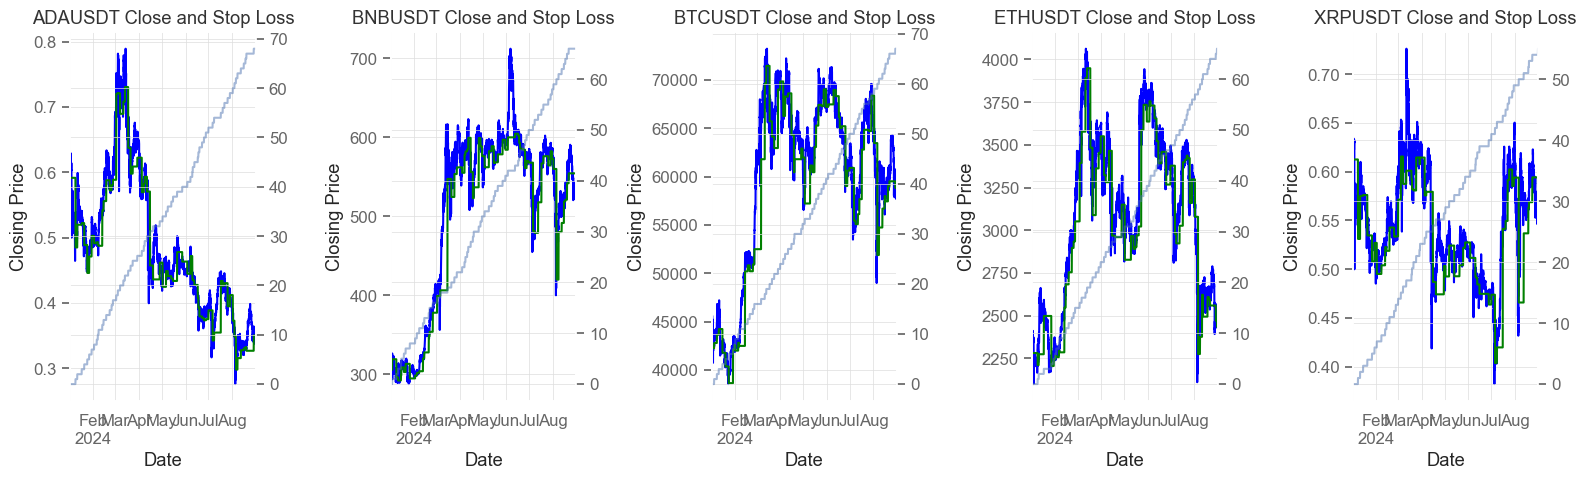

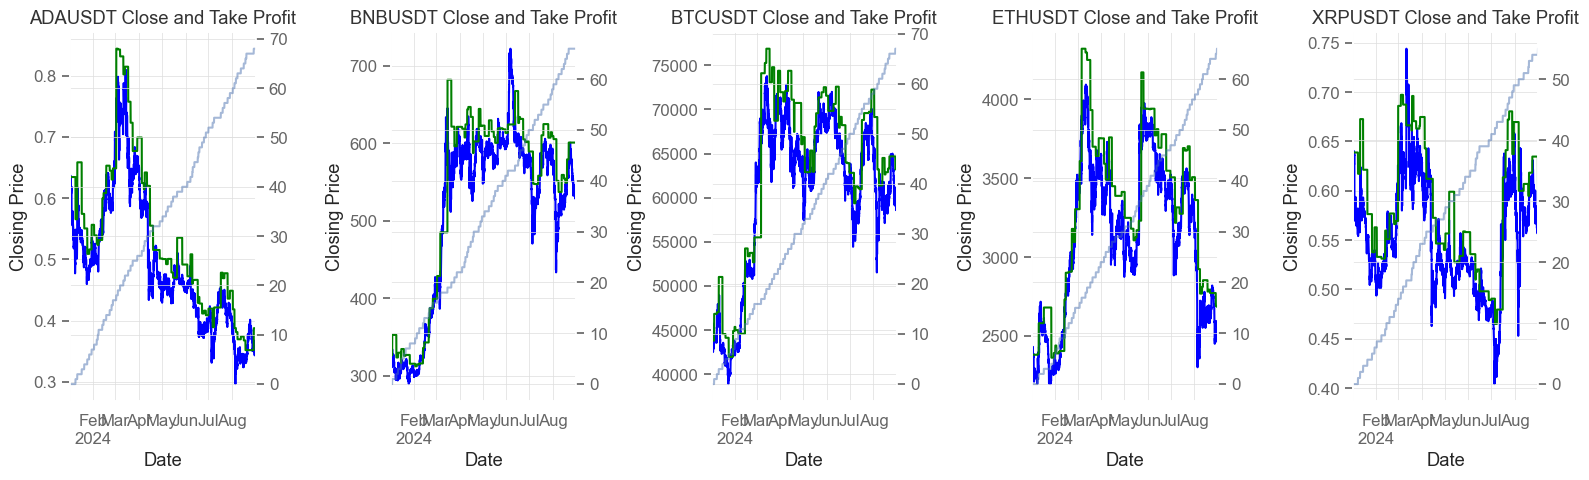

In [24]:
###### To Optimize ######
#All parameters:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling
low_freq_index = 1 #The index of the lowest frequency for the resampling
low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
max_dollar_allocation = 10000
std_window = 2
mean_window = 2
ema_window = 2
high_freq_index = 3 #The index of the highest frequency for the resampling
high_freq = all_frequency[high_freq_index] #The highest frequency for the resampling
str_length = 10
str_mult = 3
_min_pos = 0
_max_pos = 1
sl_type = 'atr'
sl_ind_length = 14
sl_ind_mult = 3
sl_signal_only = True
fixed_sl = True
tp_type = 'rr'
tp_mult = 2
tp_ind_length = 0
tp_signal_only = True
fixed_tp = True
max_perc_risk = 0.01




#Downsample the data
cal = Calculations()
#Generate a signal
tf = Trend_Following()

_df = tf.supertrend_signals(data, str_length, str_mult)

pos = Position(_df, _min_pos, _max_pos)
_df = pos.initialize_position()
sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
_df = sl.apply_stop_loss(fixed_sl, plot = True)
tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
_df = tp.apply_take_profit(fixed_tp, plot = True)

_df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
_df = pos.calculate_position(_df)

mt = Manage_Trade(_df)
_df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

#########################

_df = cal.update_all(_df)



In [25]:
_df['position']

date                        
2024-01-01 15:00:00  ADAUSDT    NaN
                     BNBUSDT    NaN
                     BTCUSDT    NaN
                     ETHUSDT    NaN
                     XRPUSDT    NaN
                               ... 
2024-08-31 23:00:00  ADAUSDT    0.0
                     BNBUSDT    0.0
                     BTCUSDT    0.0
                     ETHUSDT    1.0
                     XRPUSDT    1.0
Name: position, Length: 29205, dtype: float64

In [26]:
df = cal.downsample(_df, low_freq)

#Perform coarse analysis and filtering
coarse = Coarse()
df = coarse.volume_flag(df, max_dollar_allocation)
df = coarse.sort_by_volume(df)
df = coarse.sort_by_std(df, std_window, mean_window)
fine = Fine()
df = fine.above_ema(df, ema_window)

#apply update_univers
df['in_universe'], current_universe = update_universe(df)

C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [27]:
df.dropna()

close  creturns        high  log_return  \
date                                                                        
2024-01-02 15:00:00 BNBUSDT    308.4000  0.980916    313.4000   -0.011606   
                    ETHUSDT   2357.4800  1.026996   2371.1400   -0.004148   
2024-01-02 16:00:00 BNBUSDT    310.8000  0.988550    311.3000    0.007752   
                    ETHUSDT   2367.9100  1.031540   2369.6000    0.004414   
2024-01-02 17:00:00 BNBUSDT    310.2000  0.986641    311.2000   -0.001932   
...                                 ...       ...         ...         ...   
2024-08-31 23:00:00 ADAUSDT      0.3450  0.577020      0.3457   -0.000869   
                    BNBUSDT    532.9000  1.694975    534.1000   -0.001313   
                    BTCUSDT  58973.9900  1.388433  59056.0000   -0.000848   
                    ETHUSDT   2513.0100  1.094750   2518.7300   -0.001586   
                    XRPUSDT      0.5662  0.918858      0.5673   -0.002117   

                                    low        open       price   returns  \
date                                                                        
2024-01-02 15:00:00 BNBUSDT    305.8000    312.0000    308.4000 -0.011538   
                    ETHUSDT   2352.0400   2367.2700   2357.4800 -0.004140   
2024-01-02 16:00:00 BNBUSDT    307.5000    308.5000    310.8000  0.007782   
                    ETHUSDT   2350.1900   2357.4800   2367.9100  0.004424   
2024-01-02 17:00:00 BNBUSDT    308.7000    310.8000    310.2000 -0.001931   
...                                 ...         ...         ...       ...   
2024-08-31 23:00:00 ADAUSDT      0.3444      0.3452      0.3450 -0.000869   
                    BNBUSDT    531.8000    533.7000    532.9000 -0.001312   
                    BTCUSDT  58927.0000  59023.9900  58973.9900 -0.000847   
                    ETHUSDT   2511.2500   2517.0100   2513.0100 -0.001585   
                    XRPUSDT      0.5655      0.5673      0.5662 -0.002115   

                                   volume  volume_in_dollars  ...   htf_close  \
date                                                          ...               
2024-01-02 15:00:00 BNBUSDT  1.186873e+05       3.660317e+07  ...    312.2000   
                    ETHUSDT  2.561761e+04       6.039301e+07  ...   2355.3400   
2024-01-02 16:00:00 BNBUSDT  5.781969e+04       1.797036e+07  ...    312.2000   
                    ETHUSDT  1.891655e+04       4.479269e+07  ...   2355.3400   
2024-01-02 17:00:00 BNBUSDT  4.304223e+04       1.335170e+07  ...    312.2000   
...                                   ...                ...  ...         ...   
2024-08-31 23:00:00 ADAUSDT  4.080661e+05       1.407828e+05  ...      0.3450   
                    BNBUSDT  4.081118e+03       2.174828e+06  ...    532.9000   
                    BTCUSDT  2.835652e+02       1.672297e+07  ...  58973.9900   
                    ETHUSDT  1.698007e+03       4.267109e+06  ...   2513.0100   
                    XRPUSDT  1.039277e+06       5.884386e+05  ...      0.5662   

                               htf_volume  htf_volume_in_dollars  volume_flag  \
date                                                                            
2024-01-02 15:00:00 BNBUSDT  9.377647e+05           2.950305e+08            1   
                    ETHUSDT  4.580417e+05           1.091562e+09            1   
2024-01-02 16:00:00 BNBUSDT  9.377647e+05           2.950305e+08            1   
                    ETHUSDT  4.580417e+05           1.091562e+09            1   
2024-01-02 17:00:00 BNBUSDT  9.377647e+05           2.950305e+08            1   
...                                   ...                    ...          ...   
2024-08-31 23:00:00 ADAUSDT  2.705748e+07           9.401247e+06            1   
                    BNBUSDT  9.595407e+04           5.143237e+07            1   
                    BTCUSDT  8.798409e+03           5.198026e+08            1   
                    ETHUSDT  9.794611e+04           2.464540e+08            1   
    

<Axes: xlabel='date,None'>

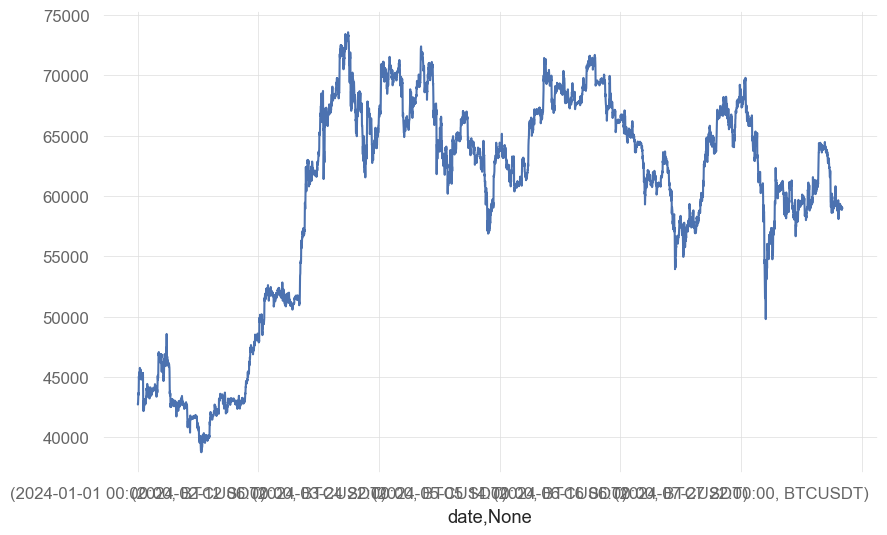

In [28]:
df.loc[(slice(None), 'BTCUSDT'), 'close'].plot()


In [29]:
df.dropna(inplace = True)

In [30]:
df = df[df['in_universe']]

In [ ]:
#Calculate transaction costs on strategy returns

#### Trading Strategy

In [31]:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling 

In [41]:
def trading_strategy(
        data,
        params = None,
        ###### To Optimize ######
        std_window = 20,
        mean_window = 20,
        ema_window = 20,
        str_length = 10,
        str_mult = 3,
        _min_pos = 0, #Has to be >= 0
        _max_pos = 1, #Has to be > 0
        sl_ind_length = 14,
        sl_ind_mult = 3,
        tp_mult = 2,
        ptp_mult = 1,
        ptp_exit_percent = 0.5,
        ###### Constants ######
        low_freq_index = 1, #The index of the lowest frequency for the resampling
        high_freq_index = 3, #The index of the highest frequency for the resampling
        max_perc_risk = 0.01,
        max_dollar_allocation = 10000,
        sl_type = 'atr',
        tp_type = 'rr',
        sl_signal_only = True,
        tp_signal_only = True,
        ptp_signal_only = True,
        tp_ind_length = 0,
        fixed_sl = True,
        fixed_tp = True
        ):
    
    if params is not None:
        if isinstance(params, list):
            std_window = params[0]
            mean_window = params[1]
            ema_window = params[2]
            str_length = params[3]
            str_mult = params[4]
            _min_pos = params[5]
            _max_pos = params[6]
            sl_ind_length = params[7]
            sl_ind_mult = params[8]
            tp_mult = params[9]
            ptp_mult = params[10]
            ptp_exit_percent = params[11]
        if isinstance(params, dict):
            std_window = params['std_window']
            mean_window = params['mean_window']
            ema_window = params['ema_window']
            str_length = params['str_length']
            str_mult = params['str_mult']
            _min_pos = params['_min_pos']
            _max_pos = params['_max_pos']
            sl_ind_length = params['sl_ind_length']
            sl_ind_mult = params['sl_ind_mult']
            tp_mult = params['tp_mult']
            ptp_mult = params['ptp_mult']
            ptp_exit_percent = params['ptp_exit_percent']
        


    if high_freq_index > low_freq_index:
        low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
        high_freq = all_frequency[high_freq_index], #The highest frequency for the resampling
            #Generally not going to be used since we are not calling the data inside the function
    
    #########################
    
    cal = Calculations()
    tf = Trend_Following()
    #Generate a signal
    

    _df = tf.supertrend_signals(data.copy(), str_length, str_mult)

    pos = Position(_df, _min_pos, _max_pos)
    _df = pos.initialize_position()
    sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
    _df = sl.apply_stop_loss(fixed_sl, plot = False)
    tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
    _df = tp.apply_take_profit(fixed_tp, plot = False)
    ptp = Take_Profit(_df, tp_type, ptp_mult, ptp_signal_only, exit_percent = ptp_exit_percent)
    _df = ptp.apply_take_profit(fixed_tp, plot = False)

    _df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
    _df = pos.calculate_position(_df)

    mt = Manage_Trade(_df)
    _df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)
    
    _df = cal.update_all(_df)

    #########################
    
    #Calculate transaction costs on strategy returns
    costs = Costs(df, maker = 0.25, taker = 0.40)
    df = costs.apply_fees() #Applies fees on strategy returns, appears on cumulative returns when applied 

    #Downsample the data
    df = cal.downsample(_df, low_freq)
    
    #########################

    #Perform coarse analysis and filtering
    coarse = Coarse()
    df = coarse.volume_flag(df, max_dollar_allocation)
    df = coarse.sort_by_volume(df)
    df = coarse.sort_by_std(df, std_window, mean_window)
    fine = Fine()
    df = fine.above_ema(df, ema_window)

    #apply update_univers
    df['in_universe'], current_universe = update_universe(df)

    df.dropna(inplace = True)

    df = df[df['in_universe']]
    
    return df



SyntaxError: expected argument value expression (2610555073.py, line 96)

In [33]:
sample_strategy = trading_strategy(data)
'strategy' in sample_strategy.columns

C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


True

In [34]:
sample_strategy

,,close,creturns,high,log_return,low,open,price,returns,volume,volume_in_dollars,...,htf_close,htf_volume,htf_volume_in_dollars,volume_flag,volume_rank,htf_std_values,std_rank,ema_20,above_ema,in_universe
date,,,,,,,,,,,,,,,,,,,,,,
2024-01-04 07:00:00,BNBUSDT,318.50,1.013041,322.30,-0.008130,317.80,321.10,318.50,-0.008097,47799.60000,1.522417e+07,...,323.70,1.133775e+06,3.614889e+08,1,3.0,0.012449,3.0,317.165256,1,True
2024-01-04 08:00:00,BNBUSDT,320.10,1.018130,321.40,0.005011,318.50,318.50,320.10,0.005024,54995.85700,1.760417e+07,...,323.70,1.133775e+06,3.614889e+08,1,3.0,0.012626,3.0,317.444755,1,True
2024-01-04 09:00:00,BNBUSDT,321.80,1.023537,324.30,0.005297,320.10,320.20,321.80,0.005311,64595.74200,2.078691e+07,...,323.70,1.133775e+06,3.614889e+08,1,3.0,0.012674,3.0,317.859540,1,True
2024-01-05 21:00:00,BTCUSDT,43946.26,1.034633,43971.10,-0.000200,43580.51,43955.07,43946.26,-0.000200,1609.24913,7.072048e+07,...,44145.11,4.807525e+04,2.100551e+09,1,5.0,0.000000,3.0,43720.126344,1,True
2024-01-05 22:00:00,BTCUSDT,43967.44,1.035131,44048.64,0.000482,43764.42,43946.26,43967.44,0.000482,1024.55085,4.504688e+07,...,44145.11,4.807525e+04,2.100551e+09,1,5.0,0.000000,3.0,43743.680025,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 10:00:00,ETHUSDT,2525.70,1.100278,2528.50,0.004643,2513.50,2514.00,2525.70,0.004654,3369.40540,8.510107e+06,...,2513.01,9.794611e+04,2.464540e+08,1,3.0,0.002632,2.0,2518.466698,1,True
2024-08-31 11:00:00,ETHUSDT,2525.50,1.100191,2529.81,-0.000079,2523.72,2525.69,2525.50,-0.000079,3381.42440,8.539787e+06,...,2513.01,9.794611e+04,2.464540e+08,1,3.0,0.002593,2.0,2519.136537,1,True
2024-08-31 12:00:00,ETHUSDT,2523.74,1.099425,2527.19,-0.000697,2522.05,2525.49,2523.74,-0.000697,3160.17240,7.975453e+06,...,2513.01,9.794611e+04,2.464540e+08,1,3.0,0.002525,2.0,2519.574962,1,True


In [35]:
# Define parameter space for optimization
param_space = {
    'std_window': Integer(5, 30),
    'mean_window': Integer(5, 30),
    'ema_window': Integer(5, 100),
    'str_length': Integer(5, 50),
    'str_mult': Integer(1, 5),
    '_min_pos': Real(0, 0.5),
    '_max_pos': Real(0, 1),
    'sl_ind_length': Integer(5, 50),
    'sl_ind_mult': Real(0.5, 5),
    'tp_mult': Integer(2, 7),
    'ptp_mult': Real(1, 2),
    'ptp_exit_percent': Real(0.1, 1)
}

In [36]:
wfo = WFO(data, 
            trading_strategy, 
            param_space, 
            train_size=2000, 
            test_size=2000, 
            step_size=2000, 
            optimize_fn="gp", 
            objective='multiple', 
            opt_freq='custom')

all_performance, all_results = wfo.walk_forward_optimization()

C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()
C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.3195356980140154


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.22563722714254633


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.13461233326546257


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.4959668683662056


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.3623552212560532


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.01566741661853035


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.48954452691278233


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.5171770798123231


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.14716852752113618


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.5334616169059332
{'std_window': 24, 'mean_window': 18, 'ema_window': 61, 'str_length': 48, 'str_mult': 3, '_min_pos': 0.1379995910112717, '_max_pos': 0.29627350570408245, 'sl_ind_length': 12, 'sl_ind_mult': 0.5703638303353727, 'tp_mult': 4, 'ptp_mult': 1.3948815181755698, 'ptp_exit_percent': 0.36413935724623436}
[24, 18, 61, 48, 3, 0.1379995910112717, 0.29627350570408245, 12, 0.5703638303353727, 4, 1.3948815181755698, 0.36413935724623436]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0.38184569177595507


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.7214720008158906


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.4480826877907148


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.0094604646099754


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.3647109768359565


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.45346835870756885


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.38184569177595507


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.7349476957115325


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.1596961138057829


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.06330583591280718


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.47241263400383166
{'std_window': 22, 'mean_window': 22, 'ema_window': 61, 'str_length': 17, 'str_mult': 3, '_min_pos': 0.19146343737689497, '_max_pos': 0.971712095389104, 'sl_ind_length': 43, 'sl_ind_mult': 3.7477828452419297, 'tp_mult': 3, 'ptp_mult': 1.256068322761324, 'ptp_exit_percent': 0.1363902305845882}
[22, 22, 61, 17, 3, 0.19146343737689497, 0.971712095389104, 43, 3.7477828452419297, 3, 1.256068322761324, 0.1363902305845882]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 2.13505650372325


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


3.287779005200965


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.7166434371498998


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


3.545625001058817


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


3.593574188773858


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.82566675813853


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


3.0796393067586303


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


3.391353109399422


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.13505650372325


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.0816689780792905


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.378598111570262
{'std_window': 5, 'mean_window': 11, 'ema_window': 28, 'str_length': 36, 'str_mult': 3, '_min_pos': 0.4165974558680823, '_max_pos': 0.1733646535077721, 'sl_ind_length': 23, 'sl_ind_mult': 1.3200623950462806, 'tp_mult': 6, 'ptp_mult': 1.425155874491245, 'ptp_exit_percent': 0.28714749658137}
[5, 11, 28, 36, 3, 0.4165974558680823, 0.1733646535077721, 23, 1.3200623950462806, 6, 1.425155874491245, 0.28714749658137]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 1.4491451703403357


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.3159956953276195


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.1493876931702953


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.8552356643579355


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.4491451703403357


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.8358934929636006


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.6517944205689725


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.3669221625392898


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.3677008212798123


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.5398928479131085


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.6974800084782622
{'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'str_length': 41, 'str_mult': 3, '_min_pos': 0.4631504392566746, '_max_pos': 0.6510770255019446, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 4, 'ptp_mult': 1.0954101164904113, 'ptp_exit_percent': 0.43373642697843984}
[5, 10, 73, 41, 3, 0.4631504392566746, 0.6510770255019446, 46, 4.325173600054098, 4, 1.0954101164904113, 0.43373642697843984]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: -1.4478711659368206


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.5002787407563307


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.8293607976813526


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.2982467475181465


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.6575745067221543


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.44252842080184


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.4083785765949133


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.4478711659368206


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.5311461491224405


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.3206627688670907


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.1301376848954106
{'std_window': 29, 'mean_window': 20, 'ema_window': 71, 'str_length': 45, 'str_mult': 3, '_min_pos': 0.14781684291885702, '_max_pos': 0.10549425983027064, 'sl_ind_length': 26, 'sl_ind_mult': 1.4829819674757514, 'tp_mult': 4, 'ptp_mult': 1.8832802589188686, 'ptp_exit_percent': 0.3919105189047466}
[29, 20, 71, 45, 3, 0.14781684291885702, 0.10549425983027064, 26, 1.4829819674757514, 4, 1.8832802589188686, 0.3919105189047466]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: -0.6076762228622727


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.23601016584865775


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.49946927365586336


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.2671091463660017


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.07472046701203988


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.6379325225687457


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.5859496233968539


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.557418448164677


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.533471358953346


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.09645508393189064


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.6076762228622727
{'std_window': 28, 'mean_window': 5, 'ema_window': 99, 'str_length': 33, 'str_mult': 3, '_min_pos': 0.003533152609858704, '_max_pos': 0.02306242504141576, 'sl_ind_length': 29, 'sl_ind_mult': 2.29937437271865, 'tp_mult': 2, 'ptp_mult': 1.9737555188414593, 'ptp_exit_percent': 0.3094942063872739}
[28, 5, 99, 33, 3, 0.003533152609858704, 0.02306242504141576, 29, 2.29937437271865, 2, 1.9737555188414593, 0.3094942063872739]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0.10807040155249183


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.7099831705809536


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.10807040155249183


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.014781886490309499


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.3701939250211914


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.3082593144822894


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.38462723088690853


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.25266991610407324


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.5291326150938164


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.21939048325956204


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.074372010126323
{'std_window': 19, 'mean_window': 6, 'ema_window': 85, 'str_length': 25, 'str_mult': 3, '_min_pos': 0.4633294328968972, '_max_pos': 0.727271995856421, 'sl_ind_length': 20, 'sl_ind_mult': 3.066997884824298, 'tp_mult': 5, 'ptp_mult': 1.9611720243493493, 'ptp_exit_percent': 0.8600804638103364}
[19, 6, 85, 25, 3, 0.4633294328968972, 0.727271995856421, 20, 3.066997884824298, 5, 1.9611720243493493, 0.8600804638103364]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: -0.12751272764707747


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.8565579981043802


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.9429463590469679


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.3932462037476551


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.6263062290131031


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.12751272764707747


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.32710338633136743


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.027677441270505712


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.26463746004598576


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.021140169333546


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.03140153139676041
{'std_window': 5, 'mean_window': 11, 'ema_window': 28, 'str_length': 36, 'str_mult': 3, '_min_pos': 0.4165974558680823, '_max_pos': 0.1733646535077721, 'sl_ind_length': 23, 'sl_ind_mult': 1.3200623950462806, 'tp_mult': 6, 'ptp_mult': 1.425155874491245, 'ptp_exit_percent': 0.28714749658137}
[5, 11, 28, 36, 3, 0.4165974558680823, 0.1733646535077721, 23, 1.3200623950462806, 6, 1.425155874491245, 0.28714749658137]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 0.562457525487065


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.0759691964516178


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.4646914759815708


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.8511454011795683


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.562457525487065


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.8254765481408629


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.3436857681291457


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.0615219128319209


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.6722225637424672


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.667270110806008


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.5636193637192749
{'std_window': 7, 'mean_window': 20, 'ema_window': 41, 'str_length': 49, 'str_mult': 3, '_min_pos': 0.4299702033681604, '_max_pos': 0.6803075385877798, 'sl_ind_length': 25, 'sl_ind_mult': 0.5596923252193994, 'tp_mult': 7, 'ptp_mult': 1.5632882178455394, 'ptp_exit_percent': 0.4468748522859246}
[7, 20, 41, 49, 3, 0.4299702033681604, 0.6803075385877798, 25, 0.5596923252193994, 7, 1.5632882178455394, 0.4468748522859246]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: -1.0133523957237183


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.12938238250857817


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.1213471445919767


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.0133523957237183


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.3464848943532509


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.0041202715361193


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.862936269626735


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.8939716472806067


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.8007543811281113


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.12206977096205758


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.9726439436044071
{'std_window': 23, 'mean_window': 8, 'ema_window': 47, 'str_length': 14, 'str_mult': 5, '_min_pos': 0.23768511159105593, '_max_pos': 0.5632755719763838, 'sl_ind_length': 36, 'sl_ind_mult': 1.1269915448264407, 'tp_mult': 5, 'ptp_mult': 1.5398410913016733, 'ptp_exit_percent': 0.2827551022612925}
[23, 8, 47, 14, 5, 0.23768511159105593, 0.5632755719763838, 36, 1.1269915448264407, 5, 1.5398410913016733, 0.2827551022612925]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: -0.06286226045998441


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.5781666940793528


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.27589693720487557


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.051678137807375096


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.07770875475414789


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.47403000787610855


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.6339122937312353


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.4185350799730778


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.06363044049965733


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-0.06286226045998441


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


0.520436978580002
{'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'str_length': 41, 'str_mult': 3, '_min_pos': 0.4631504392566746, '_max_pos': 0.6510770255019446, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 4, 'ptp_mult': 1.0954101164904113, 'ptp_exit_percent': 0.43373642697843984}
[5, 10, 73, 41, 3, 0.4631504392566746, 0.6510770255019446, 46, 4.325173600054098, 4, 1.0954101164904113, 0.43373642697843984]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: 2.4363205222253637


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.7321521246225062


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.432348750156177


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.3363215267756954


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.82171125766407


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


1.5681449778479883


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.0357964687202053


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.4363205222253637


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.3009437600294516


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.0226607028882353


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


2.2842724779216854
{'std_window': 25, 'mean_window': 10, 'ema_window': 79, 'str_length': 32, 'str_mult': 3, '_min_pos': 0.049987457909001456, '_max_pos': 0.45924889196586727, 'sl_ind_length': 20, 'sl_ind_mult': 1.1429006806487336, 'tp_mult': 5, 'ptp_mult': 1.0564115790271003, 'ptp_exit_percent': 0.7497988950401424}
[25, 10, 79, 32, 3, 0.049987457909001456, 0.45924889196586727, 20, 1.1429006806487336, 5, 1.0564115790271003, 0.7497988950401424]


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Out-of-sample performance: -2.8243379685458416


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.8243379685458416


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.6985741594086696


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.9630221835890669


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.978596364112764


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.7466518544582326


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.1841651924044747


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.9087805341405213


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-1.755772737417852


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.849946918435662


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


-2.487113200531026
{'std_window': 22, 'mean_window': 22, 'ema_window': 61, 'str_length': 17, 'str_mult': 3, '_min_pos': 0.19146343737689497, '_max_pos': 0.971712095389104, 'sl_ind_length': 43, 'sl_ind_mult': 3.7477828452419297, 'tp_mult': 3, 'ptp_mult': 1.256068322761324, 'ptp_exit_percent': 0.1363902305845882}
[22, 22, 61, 17, 3, 0.19146343737689497, 0.971712095389104, 43, 3.7477828452419297, 3, 1.256068322761324, 0.1363902305845882]
Out-of-sample performance: 0.1269092098915885


C:\Users\yassi\AppData\Local\Temp\ipykernel_4556\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [37]:
np.mean(all_performance)

0.08586094490925647

In [38]:
all_results

close  creturns        high  log_return  \
date                                                                        
2024-01-25 00:00:00 BTCUSDT  40170.1500  0.945731  40178.8400    0.002125   
2024-01-25 01:00:00 BTCUSDT  39978.8300  0.941227  40178.6200   -0.004774   
2024-01-25 02:00:00 BTCUSDT  39939.8400  0.940309  40065.6200   -0.000976   
2024-01-25 03:00:00 BTCUSDT  40012.0100  0.942008  40099.8700    0.001805   
2024-01-25 04:00:00 BTCUSDT  39956.8900  0.940710  40032.5000   -0.001379   
...                                 ...       ...         ...         ...   
2024-08-21 07:00:00 XRPUSDT      0.5982  0.970789      0.5989    0.001338   
2024-08-21 08:00:00 ADAUSDT      0.3534  0.591069      0.3602   -0.015722   
                    BTCUSDT  59443.0000  1.399474  59924.1300   -0.004515   
                    ETHUSDT   2584.8400  1.126042   2607.8700   -0.006125   
                    XRPUSDT      0.5961  0.967381      0.5995   -0.003517   

                                    low        open       price   returns  \
date                                                                        
2024-01-25 00:00:00 BTCUSDT  40012.0000  40084.8900  40170.1500  0.002127   
2024-01-25 01:00:00 BTCUSDT  39925.7900  40170.1500  39978.8300 -0.004763   
2024-01-25 02:00:00 BTCUSDT  39914.0000  39978.8400  39939.8400 -0.000975   
2024-01-25 03:00:00 BTCUSDT  39931.8600  39939.8400  40012.0100  0.001807   
2024-01-25 04:00:00 BTCUSDT  39912.0000  40012.0100  39956.8900 -0.001378   
...                                 ...         ...         ...       ...   
2024-08-21 07:00:00 XRPUSDT      0.5965      0.5973      0.5982  0.001339   
2024-08-21 08:00:00 ADAUSDT      0.3525      0.3589      0.3534 -0.015599   
                    BTCUSDT  59231.3300  59711.9900  59443.0000 -0.004505   
                    ETHUSDT   2578.6000   2600.7300   2584.8400 -0.006106   
                    XRPUSDT      0.5955      0.5982      0.5961 -0.003511   

                                   volume  volume_in_dollars  ...  \
date                                                          ...   
2024-01-25 00:00:00 BTCUSDT  1.009566e+03       4.055442e+07  ...   
2024-01-25 01:00:00 BTCUSDT  1.209844e+03       4.836813e+07  ...   
2024-01-25 02:00:00 BTCUSDT  5.562962e+02       2.221838e+07  ...   
2024-01-25 03:00:00 BTCUSDT  7.089532e+02       2.836664e+07  ...   
2024-01-25 04:00:00 BTCUSDT  7.761304e+02       3.101176e+07  ...   
...                                   ...                ...  ...   
2024-08-21 07:00:00 XRPUSDT  1.734823e+07       1.037771e+07  ...   
2024-08-21 08:00:00 ADAUSDT  7.133493e+06       2.520976e+06  ...   
                    BTCUSDT  1.071731e+03       6.370693e+07  ...   
                    ETHUSDT  8.876694e+03       2.294483e+07  ...   
                    XRPUSDT  5.793189e+06       3.453320e+06  ...   

                             SUPERT_14_5.0  SUPERTd_14_5.0  SUPERTl_14_5.0  \
date                                                                         
2024-01-25 00:00:00 BTCUSDT            NaN             NaN             NaN   
2024-01-25 01:00:00 BTCUSDT            NaN             NaN             NaN   
2024-01-25 02:00:00 BTCUSDT            NaN             NaN             NaN   
2024-01-25 03:00:00 BTCUSDT            NaN             NaN             NaN   
2024-01-25 04:00:00 BTCUSDT            NaN             NaN             NaN   
...                                    ...             ...             ...   
2024-08-21 07:00:00 XRPUSDT            NaN             NaN             NaN   
2024-08-21 08:00:00 ADAUSDT            NaN             NaN             NaN   
                    BTCUSDT            NaN             NaN             NaN   
                    ETHUSDT            NaN             NaN             NaN   
                    XRPUSDT            NaN             NaN             NaN   

                             SUPERTs_14_5.0  ema_47  SUPERT_32_3.0  \
date                                           

In [39]:
qs.stats.sharpe(all_results['strategy'].apply(np.exp) - 1)

NameError: name 'qs' is not defined

<Axes: xlabel='date,None'>

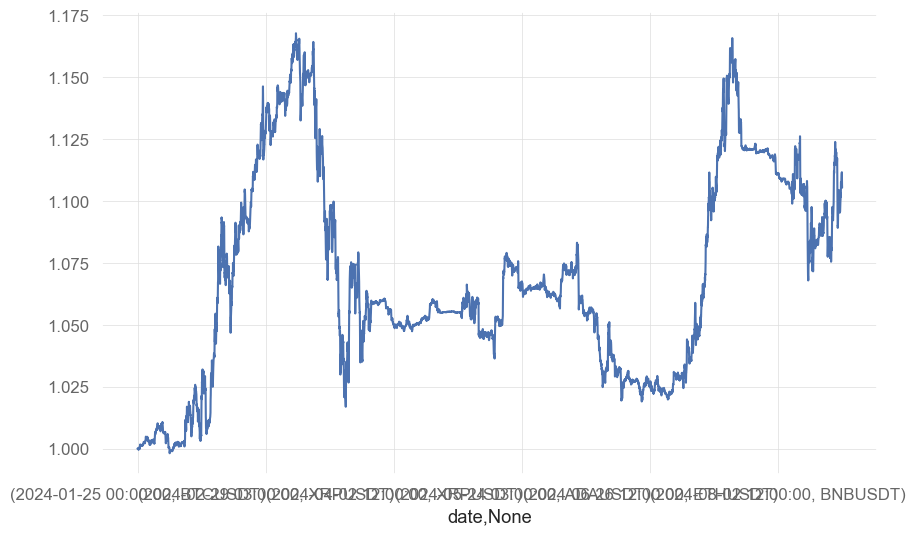

In [40]:
all_results['cstrategy'] = creturns = (all_results['strategy'] * (1/4)).cumsum().apply(np.exp)
creturns.plot()

In [ ]:
def optimize_sizes(data, trading_strategy, param_space):
    best_performance = -np.inf
    for train_size in range(1000, 3001, 500):  # Adjust the step size as needed
        for test_size in range(1000, 3001, 500):
            for step_size in range(1000, 3001, 500):
                wfo = WFO(data, 
                        trading_strategy, 
                        param_space, 
                        train_size=train_size, 
                        test_size=test_size, 
                        step_size=step_size, 
                        optimize_fn="gp", 
                        objective='sharpe', 
                        opt_freq='custom')
                print(f"Train size: {train_size}, Test size: {test_size}, Step size: {step_size}")
                all_performance, all_results = wfo.walk_forward_optimization()
                if np.mean(all_performance) > best_performance:
                    best_performance = np.mean(all_performance)
                    best_train_size = train_size
                    best_test_size = test_size
                    best_step_size = step_size
                    best_results = all_results
                print(f"Mean performance: {np.mean(all_performance)}")

    return best_train_size, best_test_size, best_step_size, best_results, best_performance

optimize_sizes(data, trading_strategy, param_space)
